# Insight Project --Birding Big Year--

In this project I intend to determine the cheapest way to win the Big Year competition by the American Birding Association (ABA), following their rules. As part of their rules they give the list of eligible birds (1116).  All the birds have to be seen with in 12:00 AM, January 1st to 11:59 PM, December 31st of the same year. 



In [1]:
import numpy as np
from datetime import datetime
import geopandas as gpd
from shapely.geometry import Point
import os
import struct

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable

from sklearn.cluster import KMeans

import pandas as pd
from pandas.io.json import json_normalize, read_json

def save_fig(name):
    fig.savefig(name,dpi=80,bbox_inches='tight', pad_inches=0.02, format = 'jpg')

%matplotlib inline

# Our goal

The list of birds from ABA that have to be found.  ABA also give us a way to rank the birds.  That information will be used to map our route and determine hotspots. ABA 1-2 will be consider low priority and 3-5 high priority. 

In [32]:
dfbirdList = pd.read_csv('./ABA_Checklist-8.0.6a.csv', usecols=[1,3,4], skiprows=1)
dfbirdList.rename(columns={' including detailed species accounts': 'Bird name', 'Unnamed: 3': '4 letter code',
                           'Unnamed: 4': 'ABA Rarity'}, inplace=True)
dfbirdList.dropna(inplace=True)
dfbirdList.reset_index(inplace=True)
dfbirdList.drop(['index'], axis=1, inplace=True)
dfbirdList['ABA TF Rarity'] = dfbirdList['ABA Rarity']//3

In [3]:
listOfBirds = list(dfbirdList['Bird name'].unique())

In [5]:
dfbirdList.head(5)

,Bird name,4 letter code,ABA Rarity,T/F Rarity
0,Black-bellied Whistling-Duck,BBWD,1.0,0.0
1,Fulvous Whistling-Duck,FUWD,1.0,0.0
2,Emperor Goose,EMGO,2.0,0.0
3,Snow Goose,SNGO,1.0,0.0
4,Ross's Goose,ROGO,1.0,0.0


# Now the ebird Data

I will start with a singe state the State of WY. Since the ebird API limits the type of request I can make, I have a downloaded cvs file.  I'm using the last two full years of data.

In [6]:
dfAll = pd.read_csv('./ebd_US-WY_201801_201912_relApr-2020/ebd_US-WY_201801_201912_relApr-2020.txt'
                ,delimiter="\t")

# dfAll = pd.read_csv('./ebd_US-WI_201001_201812_relApr-2020/ebd_US-WI_201001_201812_relApr-2020.txt'
#                 ,delimiter="\t")

I add sertain condition to satify completnes fo the data, public locations and only bird species (i.e. no hybirds). `dfReduce` will contian all the information I will be using.

In [7]:
dfAll = dfAll[(dfAll['CATEGORY'] == 'species') & (dfAll['LOCALITY TYPE'] == 'H')
              & (dfAll['ALL SPECIES REPORTED'] == 1)  & (dfAll['APPROVED'] == 1)]

In [169]:
dfReduce = dfAll.filter(['SAMPLING EVENT IDENTIFIER', 'COMMON NAME', 'LOCALITY', 'TIME OBSERVATIONS STARTED',
              'LATITUDE', 'LONGITUDE', 'OBSERVATION DATE', 'ALL SPECIES REPORTED']) 
dfReduce['OBSERVATION DATE'] = pd.to_datetime(dfReduce['OBSERVATION DATE'])
dfReduce['YEAR WEEK'] = dfReduce['OBSERVATION DATE'].dt.strftime('%W')
dfReduce['YEAR DAY'] = dfReduce['OBSERVATION DATE'].dt.strftime('%j')
dfReduce = dfReduce.merge(dfbirdList, left_on='COMMON NAME', right_on='Bird name', how = 'left')
dfReduce.drop(['Bird name'], axis=1, inplace=True)

### Now lets find the rare birds by percentils

The rare birds are going to be determine as the bottom 20%, interms of sightings (average over time).  We then also need to find what are the locations that host this birds.

In [170]:
dfPercentil = dfReduce.groupby(['COMMON NAME']).sum().filter(['ALL SPECIES REPORTED']).reset_index()
dfPercentil.rename(columns = {'ALL SPECIES REPORTED':'POS OBS'}, inplace=True)
dfPercentil['PROVABILITY'] = dfPercentil['POS OBS']/dfReduce.shape[0]

In [171]:
dfPercentil.head(5) #one hot encoding sckit lern  pivot them

,COMMON NAME,POS OBS,PROVABILITY
0,Alder Flycatcher,2,0.000009
1,American Avocet,902,0.004085
2,American Bittern,22,0.000100
3,American Coot,2484,0.011250
4,American Crow,3197,0.014479


In [172]:
# dfPercentil2 = dfReduce.groupby(['LOCALITY']).sum().filter(['ALL SPECIES REPORTED']).reset_index()
# dfPercentil2.rename(columns = {'ALL SPECIES REPORTED':'TOTAL OBS'}, inplace=True)
# dfPercentil = dfPercentil.merge(dfPercentil2, left_on='LOCALITY', right_on='LOCALITY', how = 'left')

In [173]:
dfPercentil['Percentil TF Rarity'] = list(map(lambda x: 0 if x > dfPercentil.quantile(.1)[0] else 1, 
                                        dfPercentil['PROVABILITY']))

In [174]:
dfReduce = dfReduce.merge(dfPercentil, left_on='COMMON NAME', right_on='COMMON NAME', how = 'left')

In [175]:
dfReduce['Go/Nogo'] = list(map(lambda x, y: 1 if (x ==1 or y ==1) else 0, 
                                        dfReduce['ABA TF Rarity'],dfReduce['Percentil TF Rarity']))

In [176]:
dfReduce.head(5)

,SAMPLING EVENT IDENTIFIER,COMMON NAME,LOCALITY,TIME OBSERVATIONS STARTED,LATITUDE,LONGITUDE,OBSERVATION DATE,ALL SPECIES REPORTED,YEAR WEEK,YEAR DAY,4 letter code,ABA Rarity,ABA TF Rarity,POS OBS,PROVABILITY,Percentil TF Rarity,Go/Nogo
0,S46454713,Mallard,Beck & Alkali Lakes,15:26:00,44.509697,-109.037697,2018-06-10,1,23,161,MALL,1.0,0.0,7051,0.031933,1,1
1,S49646176,Northern Goshawk,Commissary Ridge HawkWatch,09:00:00,42.024710,-110.589578,2018-10-31,1,44,304,NOGO,1.0,0.0,77,0.000349,1,1
2,S45850159,Mallard,Sand Creek Rd--Laramie to Hutton Lake NWR,12:58:00,41.222826,-105.636141,2018-05-19,1,20,139,MALL,1.0,0.0,7051,0.031933,1,1
3,S43942518,Mallard,Laramie Plains Lakes--Blake's Pond,08:08:00,41.231888,-105.823067,2018-03-25,1,12,084,MALL,1.0,0.0,7051,0.031933,1,1
4,S50217902,Harris's Sparrow,Lake De Smet,11:27:00,44.475502,-106.748357,2018-10-14,1,41,287,HASP,1.0,0.0,19,0.000086,1,1


# Is time for some plots!

In [ ]:
country = gpd.read_file('/Users/casanova/DocumentsHere/Insight/gz_2010_us_040_00_5m.json')

In [ ]:
bidName = 'American Crow'
state = 'Wyoming'

In [ ]:
# fig, ax = plt.subplots(1, figsize=(10,15))
# base = country[country['NAME'].isin([state]) == True].plot(ax=ax, color='#3B3C6E', alpha = 0.5)
# im = ax.scatter(bidsOut[bidsOut['COMMON NAME'] == bidName]['LONGITUDE'],
#            bidsOut[bidsOut['COMMON NAME'] == bidName]['LATITUDE'],
#           c = list(bidsOut[bidsOut['COMMON NAME'] == bidName]['POSITIVE OBS']))
# ax.set_ylabel(r'Latitude [$^o$]')
# ax.set_xlabel(r'Longitude [$^o$]')

# plt.text(-107, 45.01, r'{} on {}'.format(bidName,day), color='k',size=15)
# divider = make_axes_locatable(ax)
# cax = divider.append_axes('right', size='5%', pad=0.05)
# fig.colorbar(im, cax = cax, orientation='vertical')

# plt.show()
# save_fig('/Users/casanova/DocumentsHere/Insight/{}{}{}.jpg'.format(state,bidName,day))


# Now the weather data

The data will come from PRISM

In [ ]:
def parse_header(hdr):
    contents = open(hdr).read()
    lines = contents.strip().splitlines()
    header = {}
    for li in lines:
        key, _, value = li.partition(" ")
        header[key] = value.strip()

    return header

def parse_bil(path, rows, cols, dtype):
    # where you put the extracted BIL file
    fi = open(path, "rb")
    contents = fi.read()
    fi.close()

    # unpack binary data into a flat tuple z
    n = int(rows*cols)
    if dtype == "FLOAT":
        s = "<%df" % (n,)
    else: # spec says to assume unsigned int if no type specified..
        s = "<%dH" % (n,) # unsigned int
    z = struct.unpack(s, contents)

    values = np.zeros((rows,cols))
    
    for r in range(rows):
        for c in range(cols):
            val = z[(cols*r)+c]
            if (val <= -6000):
                # may not be needed depending on format, and the "magic number"
                # value used for 'void' or missing data
                val= np.nan
            values[r][c]=val
    return values

def geoloc_rc(r,c):
    lat = float(hdrInfo['ULYMAP']) - r*float(hdrInfo['YDIM'])
    lon = float(hdrInfo['ULYMAP']) + c*float(hdrInfo['XDIM'])
    return lat, lon
    
def geoloc_ll(lat,long):
    r = -1*(lat - float(hdrInfo['ULYMAP']))/float(hdrInfo['YDIM'])
    c = (lon - float(hdrInfo['ULYMAP']))/float(hdrInfo['XDIM'])
    return r, c

def findweather_from_coord(Plat, Plon, WeatherMat):
    latRange = np.linspace(float(hdrInfo['ULYMAP']),float(hdrInfo['ULYMAP'])-float(hdrInfo['YDIM'])
                           *float(hdrInfo['NROWS']),float(hdrInfo['NROWS']))
    lonRange = np.linspace(float(hdrInfo['ULXMAP']),float(hdrInfo['ULXMAP'])+float(hdrInfo['XDIM'])
                           *float(hdrInfo['NCOLS']),float(hdrInfo['NCOLS']))
    Pr,Pc = np.argmin(np.abs(latRange-Plat)), np.argmin(np.abs(lonRange-Plon))
    
    return  WeatherMat[Pr,Pc], Pr, Pc
    

In [ ]:
hdrInfo = parse_header('../../Downloads/PRISM_ppt_stable_4kmD2_20180101_20181231_bil/PRISM_ppt_stable_4kmD2_20180101_bil.hdr')

In [ ]:
hdrInfo

In [ ]:
out1 = parse_bil('../../Downloads/PRISM_ppt_stable_4kmD2_20180101_20181231_bil/PRISM_ppt_stable_4kmD2_20180401_bil.bil',
          int(hdrInfo['NROWS']), int(hdrInfo['NCOLS']), hdrInfo['PIXELTYPE'])

In [ ]:
findweather_from_coord(43.0731, -89.4012, out1)

In [ ]:
fig,ax = plt.subplots(1)
ax.imshow((out1))
rect = mpatches.Rectangle((854-10, 164-10),20,20,linewidth=2,edgecolor='r',facecolor='none')
ax.add_patch(rect)
plt.show()

# Is time for some ML

I'll be using a Logistic Regression to determine if I should go to a place or not.  To determine if I should go or not has been already introduce and that is my external parameter.  The way is currently set up is that the bottome 20 percentile and 2-5 ABA rarity code birds select locations that I should visit. 

In [ ]:
y = dfReduce[(dfReduce['YEAR DAY'] >= 0) & (dfReduce['YEAR DAY'] < 7)]['Go/Nogo'].values

use_columns = ['LATITUDE', 'LONGITUDE','YEAR DAY']
#        ,'YEAR DAY'] # 'TIME OBSERVATIONS STARTED'
# dfReduce['TIME OBSERVATIONS STARTED'] = pd.to_datetime(dfReduce['TIME OBSERVATIONS STARTED'],format= '%H:%M:%S' )

X = dfReduce[(dfReduce['YEAR DAY'] >= 0) & (dfReduce['YEAR DAY'] < 7)][use_columns]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=432545)

In [ ]:
model = LogisticRegression(class_weight={0:2,1:60})

In [ ]:
model.fit(X_train, y_train)

In [ ]:
print(model.score(X_test,y_test))

In [ ]:
# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = np.array(X)[:, 0].min() - .5, np.array(X)[:, 0].max() + .5
y_min, y_max = np.array(X)[:, 1].min() - .5, np.array(X)[:, 1].max() + .5

h = .02  # step size in the mesh
xx, yy, tt = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h), np.arange(1, 366, 1))

# xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = model.predict(np.c_[xx.ravel(), yy.ravel(), tt.ravel()])
Z = Z.reshape(xx.shape)

In [ ]:
plt.pcolormesh(xx, yy,Z, cmap=plt.cm.Reds)
plt.scatter(dfReduce[dfReduce['Go/Nogo'] == 0]['LATITUDE'],dfReduce[dfReduce['Go/Nogo'] == 0]['LONGITUDE'],
            c=dfReduce[dfReduce['Go/Nogo'] == 0]['Go/Nogo'].values, cmap=plt.cm.Paired)
plt.scatter(dfReduce[dfReduce['Go/Nogo'] == 1]['LATITUDE'],dfReduce[dfReduce['Go/Nogo'] == 1]['LONGITUDE'],
            c=dfReduce[dfReduce['Go/Nogo'] == 1]['Go/Nogo'].values, cmap=plt.cm.Greens)
plt.show()

In [ ]:
model.coef_

In [ ]:
model.intercept_

In [ ]:
Z.min()

In [ ]:
Z.max()

In [ ]:
import statsmodels.api as sm
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

In [ ]:
y_pred = model.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(model.score(X_test, y_test)))

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

In [ ]:
# import seaborn as sns

# plt.figure(figsize=(10,5))
# sns.scatterplot(data=dfReduce,x='LATITUDE',y='LONGITUDE',hue='Go/Nogo')

In [ ]:
roc_auc_score(y,LogisticRegression(C=1e9,class_weight={0:1,1:90}).fit(X,y).predict(X))

In [ ]:
roc_auc_score(y,LogisticRegression(C=1e9,class_weight='balanced').fit(X,y).predict(X))

In [ ]:
import numpy as np

# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 64, 1000, 100, 10

# Create random input and output data
x = np.random.randn(N, D_in)
y = np.random.randn(N, D_out)

# Randomly initialize weights
w1 = np.random.randn(D_in, H)
w2 = np.random.randn(H, D_out)

In [ ]:
x.shape

# Let do the k-mean clustering

In [247]:
kmeans = KMeans(init='k-means++', n_clusters=11, n_init=10)
dfKMeans = dfReduce.filter(['LATITUDE', 'LONGITUDE', 'LOCALITY']).drop_duplicates()

In [248]:
kmeans.fit(dfKMeans.filter(['LATITUDE', 'LONGITUDE']))

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=11, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [249]:
centroids = kmeans.cluster_centers_

In [250]:
centroids[:,1]

array([-106.77800424, -110.55984165, -109.01093505, -104.75786005,
       -107.11864404, -110.04901191, -104.82796713, -106.51627898,
       -109.04644762, -110.66661181, -105.37879048])

In [251]:
plotter = dfReduce.filter(['LATITUDE', 'LONGITUDE']).drop_duplicates()

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = np.min(plotter['LATITUDE']),  np.max(plotter['LATITUDE'])
y_min, y_max = np.min(plotter['LONGITUDE']), np.max(plotter['LONGITUDE'])
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)


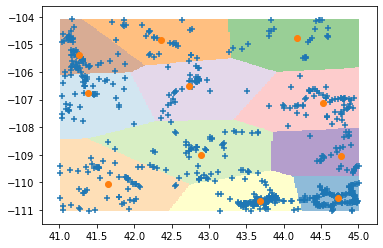

In [252]:
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower', alpha = 0.5)
plt.scatter(plotter['LATITUDE'],plotter['LONGITUDE'], marker = '+')
plt.scatter(centroids[:,0], centroids[:,1])
plt.show()


In [253]:
kmeans.labels_[:5]

array([ 8,  5, 10, 10,  4], dtype=int32)

In [254]:
kmeans.predict([[42.024710,-110.589578]])

array([5], dtype=int32)

In [255]:
dfKMeans['K-cluster'] = np.array(kmeans.labels_)

In [256]:
dfReduce.head(5)

,SAMPLING EVENT IDENTIFIER,COMMON NAME,LOCALITY,TIME OBSERVATIONS STARTED,LATITUDE,LONGITUDE,OBSERVATION DATE,ALL SPECIES REPORTED,YEAR WEEK,YEAR DAY,4 letter code,ABA Rarity,ABA TF Rarity,POS OBS,PROVABILITY,Percentil TF Rarity,Go/Nogo
0,S46454713,Mallard,Beck & Alkali Lakes,15:26:00,44.509697,-109.037697,2018-06-10,1,23,161,MALL,1.0,0.0,7051,0.031933,1,1
1,S49646176,Northern Goshawk,Commissary Ridge HawkWatch,09:00:00,42.024710,-110.589578,2018-10-31,1,44,304,NOGO,1.0,0.0,77,0.000349,1,1
2,S45850159,Mallard,Sand Creek Rd--Laramie to Hutton Lake NWR,12:58:00,41.222826,-105.636141,2018-05-19,1,20,139,MALL,1.0,0.0,7051,0.031933,1,1
3,S43942518,Mallard,Laramie Plains Lakes--Blake's Pond,08:08:00,41.231888,-105.823067,2018-03-25,1,12,084,MALL,1.0,0.0,7051,0.031933,1,1
4,S50217902,Harris's Sparrow,Lake De Smet,11:27:00,44.475502,-106.748357,2018-10-14,1,41,287,HASP,1.0,0.0,19,0.000086,1,1


In [257]:
dfKMeans.head(5)

,LATITUDE,LONGITUDE,LOCALITY,K-cluster
0,44.509697,-109.037697,Beck & Alkali Lakes,8
1,42.024710,-110.589578,Commissary Ridge HawkWatch,5
2,41.222826,-105.636141,Sand Creek Rd--Laramie to Hutton Lake NWR,10
3,41.231888,-105.823067,Laramie Plains Lakes--Blake's Pond,10
4,44.475502,-106.748357,Lake De Smet,4


In [264]:
dfKCluster = dfReduce.merge(dfKMeans.filter(['LOCALITY','K-cluster']),
                            left_on='LOCALITY', right_on='LOCALITY', how = 'left').filter(['COMMON NAME','ALL SPECIES REPORTED','YEAR WEEK', 'K-cluster'])
                                                                                          
# dfReduce.drop(['Bird name'], axis=1, inplace=True)

In [265]:
dfKCluster.head(5)

,COMMON NAME,ALL SPECIES REPORTED,YEAR WEEK,K-cluster
0,Mallard,1,23,8
1,Northern Goshawk,1,44,5
2,Mallard,1,20,10
3,Mallard,1,12,10
4,Harris's Sparrow,1,41,4


In [271]:
dfPercentilK1 = dfKCluster.groupby(['COMMON NAME','K-cluster']).sum().filter(['ALL SPECIES REPORTED']).reset_index()
dfPercentilK1.rename(columns = {'ALL SPECIES REPORTED':'POS OBS'}, inplace=True)
# dfPercentilK1['PROVABILITY'] = dfPercentilK1['POS OBS']/dfReduce.shape[0]

In [272]:
dfPercentilK1.head(5)

,COMMON NAME,K-cluster,POS OBS
0,Alder Flycatcher,10,2
1,American Avocet,0,116
2,American Avocet,1,50
3,American Avocet,2,112
4,American Avocet,3,29


In [273]:
dfPercentilK1 = dfKCluster.groupby(['K-cluster']).sum().filter(['ALL SPECIES REPORTED']).reset_index()
dfPercentilK2.rename(columns = {'ALL SPECIES REPORTED':'TOT OBS'}, inplace=True)
dfPercentilK2.head(5)

,K-cluster,TOT OBS
0,0,10302
1,1,30797
2,2,21641
3,3,4560
4,4,18560


In [284]:
df = dfPercentilK1.merge(dfPercentilK2, left_on='K-cluster', right_on='K-cluster', how = 'left')
df['POS PROB'] = df['POS OBS']/df['TOT OBS']
# df.set_index('COMMON NAME', inplace=True)
df.head(5)

,COMMON NAME,K-cluster,POS OBS,TOT OBS,POS PROB
0,Alder Flycatcher,10,2,57431,0.000035
1,American Avocet,0,116,10302,0.011260
2,American Avocet,1,50,30797,0.001624
3,American Avocet,2,112,21641,0.005175
4,American Avocet,3,29,4560,0.006360


In [294]:
df[df['COMMON NAME']=='American Avocet']['POS PROB'].quantile(.5)

0.005175361582181969

In [ ]:
df['PROB TF'] = list(map(lambda x: 0 if x > dfPercentil.quantile(.1)[0] else 1, 
                                        dfPercentil['PROVABILITY']))

In [299]:
np.unique(df['COMMON NAME'].values)

array(['Alder Flycatcher', 'American Avocet', 'American Bittern',
       'American Coot', 'American Crow', 'American Dipper',
       'American Golden-Plover', 'American Goldfinch', 'American Kestrel',
       'American Pipit', 'American Redstart', 'American Robin',
       'American Three-toed Woodpecker', 'American Tree Sparrow',
       'American White Pelican', 'American Wigeon', 'Arctic Tern',
       'Ash-throated Flycatcher', "Baird's Sandpiper", "Baird's Sparrow",
       'Bald Eagle', 'Baltimore Oriole', 'Bank Swallow', 'Barn Swallow',
       "Barrow's Goldeneye", 'Belted Kingfisher', "Bewick's Wren",
       'Black Phoebe', 'Black Rosy-Finch', 'Black Scoter', 'Black Tern',
       'Black-and-white Warbler', 'Black-backed Woodpecker',
       'Black-bellied Plover', 'Black-billed Magpie',
       'Black-capped Chickadee', 'Black-chinned Hummingbird',
       'Black-crowned Night-Heron', 'Black-headed Grosbeak',
       'Black-necked Stilt', 'Black-throated Blue Warbler',
       'Black-thr

In [301]:
df.shape[0]

2463

In [302]:
df.loc[0]

COMMON NAME    Alder Flycatcher
K-cluster                    10
POS OBS                       2
TOT OBS                   57431
POS PROB            3.48244e-05
Name: 0, dtype: object

In [ ]:
for i in range(0,df.shape[0]):
    